# Подключаем все нужные нам библиотеки

In [2]:
import numpy as np
import os
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Загрузим наш датасет

In [3]:
root_folder = "dataset"
all_files = {}

for folder in next(os.walk(root_folder))[1]:
    path = os.path.join(root_folder, folder)
    all_files[folder] = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

In [4]:
count = {'sick': 0, 'healthy': 0}
Waves = []
Intensities = []
classifications = []

for folder in list(all_files):
    for txt in all_files[folder]:
        df = pd.read_csv(
            os.path.join(root_folder, folder, txt), sep='\t', skiprows=[0],
            header=None, names=['Wave', 'Intensity'])

        Waves.append(list(df["Wave"].to_numpy()))
        Intensities.append(list(df["Intensity"].to_numpy()))

        if 'healthy' in folder:
            classifications.append([0])
        if 'sick' in folder:
            classifications.append([1])
        
        count[folder] += 1
        
print(count)

{'sick': 125, 'healthy': 432}


## Рассмотрим в каком виде нам подаются данные.
Тут мы видит 2D график вида X (Wave) - длина волны, Y (Intensity) - сила волны

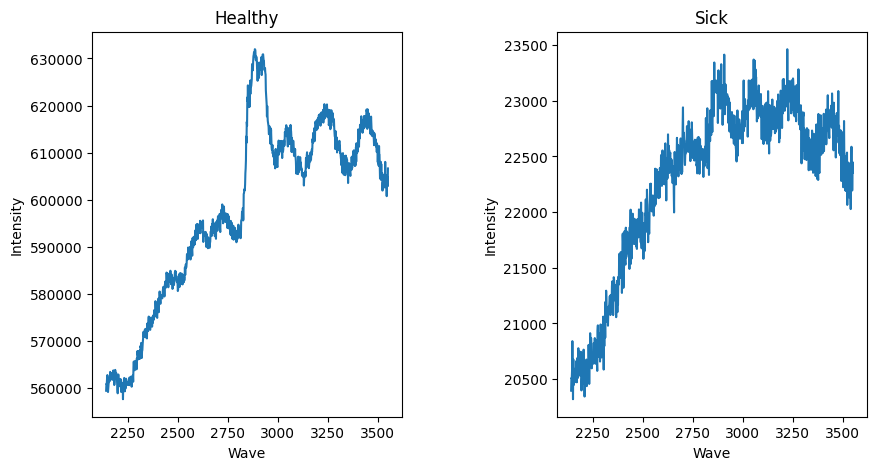

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
healthy_index = 0
sick_index = 432

axs[0].plot(Waves[healthy_index], Intensities[healthy_index])
axs[0].set_title('Healthy')
axs[0].set_xlabel('Wave')
axs[0].set_ylabel('Intensity')

axs[1].plot(Waves[sick_index], Intensities[sick_index])
axs[1].set_title('Sick')
axs[1].set_xlabel('Wave')
axs[1].set_ylabel('Intensity')

plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

# Обработка данных 
Теперь нужно сделать **Feature Engineering**, то есть из сырых данных (графиков), получить вполне понятные показатели для каждой единицы измерения. Чем больше признаков мы отберем, тем лучше. Воспользуемся базовыми статистиками: среднее, минимум, максимум, пенцентили, размах, медиана, стандартное отклонение дисперсия, коэффициенты корреляции.

In [6]:
from scipy.stats import skew, kurtosis

def extract_features(x, y):
    # Features Wave
    min_x = np.min(x) # Минимум
    max_x = np.max(x) # Максимум
    percentile_25_x = np.percentile(x, 25) # 25% перцентиль
    percentile_50_x = np.percentile(x, 50) # 50% перцентиль
    percentile_75_x = np.percentile(x, 75) # 75% перцентиль
    range_x = np.ptp(x, 0) # размах (макс - мин)
    mean_x = np.mean(x) # Среднее
    median_x = np.median(x) # Медиана
    std_dev_x = np.std(x) # Стандартное отклонение
    variance_x = np.var(x) # Дисперсия
    skewness_x = skew(x.flatten()) # Асимметрия
    kurtosis_x = kurtosis(x.flatten()) # Коэффициент эксцесса
    
    # Features Intensity
    min_y = np.min(y) # Минимум
    max_y = np.max(y) # Максимум
    percentile_25_y = np.percentile(y, 25) # 25% перцентиль
    percentile_50_y = np.percentile(y, 50) # 50% перцентиль
    percentile_75_y = np.percentile(y, 75) # 75% перцентиль
    range_y = np.ptp(y, 0) # размах (макс - мин)
    mean_y = np.mean(y) # Среднее
    median_y = np.median(y) # Медиана
    std_dev_y = np.std(y) # Стандартное отклонение
    variance_y = np.var(y) # Дисперсия
    skewness_y = skew(y.flatten()) # Асимметрия
    kurtosis_y = kurtosis(y.flatten()) # Коэффициент эксцесса
    
    # Features Both
    corr_coef = np.correlate(x, y, mode='valid')[0] # коэффициент корреляции
    correlation = np.corrcoef([x, y])[0, 1] # корреляция Пирсона
    covariance = np.cov(np.array([x, y])) # ковариация
    cov_x_x = covariance[0, 0]
    cov_x_y = covariance[0, 1]
    cov_y_y = covariance[1, 1]

    return [
        min_x, max_x, percentile_25_x, percentile_50_x, percentile_75_x, range_x, mean_x, median_x, std_dev_x, variance_x, skewness_x, kurtosis_x,
        min_y, max_y, percentile_25_y, percentile_50_y, percentile_75_y, range_y, mean_y, median_y, std_dev_y, variance_y, skewness_y, kurtosis_y,
        corr_coef, correlation, cov_x_x, cov_x_y, cov_y_y,
        ]

features = []

for index in range(len(Waves)):
    # Data
    x = np.asarray(Waves[index])
    y = np.asarray(Intensities[index])
    
    features.append(extract_features(x, y))

## Разделение выборки
Разделим выборку на обучающую и тестовую, не забывая о балансе классов в выборках (параметр **stratify**).

In [13]:
from sklearn.model_selection import train_test_split

# initial data
X_train = np.asarray(features)
Y_train = np.asarray(classifications)
print(X_train.shape)
print(Y_train.shape)
# split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=0)
print(f'Total amount of train measurements: {x_train.shape[0]}')
print(f'Total amount of test measurements: {x_test.shape[0]}')

(557, 29)
(557, 1)
Total amount of train measurements: 445
Total amount of test measurements: 112


## Напишем функцию для вывода всех нужных нам метрик классификации

Основной фокус будем делать на метрики `precision`, `recall`, `f_score`

In [14]:
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, recall_score, precision_score, f1_score

results = {}

def get_results(model_name, y_pred):
    print(f"{model_name} model")
    print("accuracy: ", accuracy_score(y_test, y_pred))

    confusion_mat = confusion_matrix(y_test, y_pred)
    print(f"""\nconfusion matrix
TP={confusion_mat[1][1]} FP={confusion_mat[0][1]}
FN={confusion_mat[1][0]} TN={confusion_mat[0][0]}\n""")
    
    precision = precision_score(y_test, y_pred) # precision = (TP) / (TP + FP)
    recall = recall_score(y_test, y_pred) # recall = (TP) / (TP + FN)
    f1 = f1_score(y_test, y_pred) # f1 = 2 * precision * recall / (precision + recall)

    print("precision: ", precision)
    print("recall: ", recall)
    print("f1_score: ", f1)
    
    results[model_name] = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# Baseline
Сначала попробуем воспользоваться моделями из классического машинного обучения,
это будут линейные модели ``LogisticRegression`` и ``SVM``

Предобработаем данные для линейных моделей используя обычную нормировку 

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(np.array(x_train_scaled).shape)
print(np.array(x_test_scaled).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)

(445, 29)
(112, 29)
(445, 1)
(112, 1)


## Модель логистической регрессии

In [246]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid_log = [{
    'penalty': ['l1', 'l2'],
    'class_weight': [{0: 1, 1: weight_sick} for weight_sick in range(3, 5)], 
    'C': list(np.logspace(-1, 1, 4)),
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200, 300]
}]

log_reg_model = LogisticRegression() 
grid_search_log = GridSearchCV(log_reg_model, param_grid_log, cv=5, verbose=3)
grid_search_log.fit(x_train_scaled, y_train)

log_reg_model = grid_search_log.best_estimator_
y_pred_log_reg_model = log_reg_model.predict(x_test_scaled)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=0.1, class_weight={0: 1, 1: 3}, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, class_weight={0: 1, 1: 3}, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, class_weight={0: 1, 1: 3}, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, class_weight={0: 1, 1: 3}, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, class_weight={0: 1, 1: 3}, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, class_weight={0: 1, 1: 3}, max_iter=200, penalty=l1, solver=liblinear;, score=0.820 total time=   0.0s
[CV 2/5] END C=0.1, class_weight={0: 1, 1: 3}, max_iter=200, penalty=l1, solver=liblinear;, score=0.764 total time=   0.0s
[CV 3/5] END C=0.1, class_weight={0: 1, 1: 3}, max_iter=200, penalty=l1, solver=liblinear;, score=0.798 tot

In [247]:
get_results("Logistic Regression", y_pred_log_reg_model)

Logistic Regression model
accuracy:  0.8125

confusion matrix
TP=19 FP=15
FN=6 TN=72

precision:  0.5588235294117647
recall:  0.76
f1_score:  0.6440677966101694


## Метод опорных векторов

In [248]:
# SVM model
from sklearn.svm import LinearSVC

param_grid_svm = [{
    'penalty': ['l1', 'l2'],
    'class_weight': [{0: 1, 1: weight_sick} for weight_sick in range(3, 5)], 
    'C': list(np.logspace(-1, 1, 4)),
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [100, 300]
}]

SVM = LinearSVC() 
grid_search_svm = GridSearchCV(SVM, param_grid_svm, cv=5, verbose=3)
grid_search_svm.fit(x_train_scaled, y_train)

SVM = grid_search_svm.best_estimator_
y_pred_svm = SVM.predict(x_test_scaled)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=0.1, class_weight={0: 1, 1: 3}, loss=hinge, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, class_weight={0: 1, 1: 3}, loss=hinge, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, class_weight={0: 1, 1: 3}, loss=hinge, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, class_weight={0: 1, 1: 3}, loss=hinge, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, class_weight={0: 1, 1: 3}, loss=hinge, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, class_weight={0: 1, 1: 3}, loss=hinge, max_iter=100, penalty=l2;, score=0.820 total time=   0.0s
[CV 2/5] END C=0.1, class_weight={0: 1, 1: 3}, loss=hinge, max_iter=100, penalty=l2;, score=0.764 total time=   0.0s
[CV 3/5] END C=0.1, class_weight={0: 1, 1: 3}, loss=hinge, max_iter=100, penalty=l2;, score=0.798 total time=   0.0s
[CV 4/5] END

In [249]:
get_results("SVM", y_pred_svm)

SVM model
accuracy:  0.8125

confusion matrix
TP=20 FP=16
FN=5 TN=71

precision:  0.5555555555555556
recall:  0.8
f1_score:  0.6557377049180327


Возможно `accuracy` и большой, но не забываем, что это из-за дисбаланса классов, ведь в нашей выборке всего 25% больный тканей (положительный класс). Такие метрики как `recall_score`, `precision_score`, `f1_score` дают понять нам, что наш алгоритм далеко не самый лучший. Заметим, что Логистическая регрессия показала себя примерно так же, как `SVM`, хотя `SVM` фокусируется лишь на разделении выборки и не думает о предсказаниях вероятностей и должен выдавать лучшее качество.

## Модель градиентного бустинга

In [263]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_boost = [{
    'learning_rate': list(np.logspace(-1, 0, 3)),
    'n_estimators': [100, 130],
    'criterion': ['squared_error'],
    'min_samples_split': [3, 4],
    'max_depth': [4],
}]

grad_model = GradientBoostingClassifier()
grid_search_boost = GridSearchCV(grad_model, param_grid_boost, cv=4, verbose=3)
grid_search_boost.fit(x_train, y_train)

grad_model = grid_search_boost.best_estimator_
y_pred_boosting = grad_model.predict(x_test)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4] END criterion=squared_error, learning_rate=0.1, max_depth=4, min_samples_split=3, n_estimators=100;, score=0.920 total time=   0.2s
[CV 2/4] END criterion=squared_error, learning_rate=0.1, max_depth=4, min_samples_split=3, n_estimators=100;, score=0.919 total time=   0.2s
[CV 3/4] END criterion=squared_error, learning_rate=0.1, max_depth=4, min_samples_split=3, n_estimators=100;, score=0.937 total time=   0.2s
[CV 4/4] END criterion=squared_error, learning_rate=0.1, max_depth=4, min_samples_split=3, n_estimators=100;, score=0.901 total time=   0.2s
[CV 1/4] END criterion=squared_error, learning_rate=0.1, max_depth=4, min_samples_split=3, n_estimators=130;, score=0.911 total time=   0.3s
[CV 2/4] END criterion=squared_error, learning_rate=0.1, max_depth=4, min_samples_split=3, n_estimators=130;, score=0.919 total time=   0.3s
[CV 3/4] END criterion=squared_error, learning_rate=0.1, max_depth=4, min_samples_split=3, n_

In [265]:
get_results("Gradient Boosting", y_pred_boosting)

Gradient Boosting model
accuracy:  0.9107142857142857

confusion matrix
TP=19 FP=4
FN=6 TN=83

precision:  0.8260869565217391
recall:  0.76
f1_score:  0.7916666666666666


Результат радует, видим значительное повышение метрик `precision` и `recall`, это значит, что модель хорошо научилась обобщать и находить закономерность в данных, не зря Градиентный Бустинг называются лучшей моделью для табличных данных. Мы смогли бы получить лучший результат, если бы имели датасет побольше.

Также рассмотрим топ-5 самых важных признаков для модели бустинга

In [29]:
imp = sorted([(grad_model.feature_importances_[i], i) for i in range(len(grad_model.feature_importances_))], key=lambda x: -x[0])
for i in range(min(5, len(imp))):
    print(imp[i][0], imp[i][1])

0.3391874536399266 25
0.09476169247318508 13
0.08886718349562922 12
0.08344162929295455 23
0.06575104589870749 14


Получаем по убыванию важности признаки:
1. коэффициент корреляция Wave-Intensity
2. минимальный Intensity
3. коэффициент эксцесса (мера распределения около среднего)
4. Дисперсия Intensity
5. максимальный Intensity
   
Интересно, что тут нет информации про Wave, важнее оказались зависимость шкал измерения между собой и показания Intensity

## Модель нейронных сетей
Теперь попробуем обучить нейросеть. В наших данных нет пространственной информации, поэтому здесь использовать сверточные нейросети будет неуместно.  Будем использовать нейросеть с архитектурой `DenseNet`. Опишем реализацию нашей модели в классе `Net` и функцию обучения с гиперпараметрами `train_network`.

In [252]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self, activations):
        super(Net, self).__init__()
        self.activations = activations
        
        self.linear1 = nn.Linear(29, 256)
        self.linear2 = nn.Linear(29 + 256, 256)
        self.linear3 = nn.Linear(29 + 256 + 256, 2) 
        # добавление слоев в модель не улучшает качество,
        # так как модель ограничена зависимостью ответа от входных данных,
        # то есть она уже выделила максимум информации из поданных признаков.
        
        self.softmax = nn.Softmax()

    def forward(self, x):
        input_1 = x
        x_1 = self.activations[0](self.linear1(input_1))

        input_2 = torch.cat((x, x_1), dim=1)
        x_2 = self.activations[1](self.linear2(input_2))

        input_3 = torch.cat((x, x_1, x_2), dim=1)
        x_3 = self.softmax(self.linear3(input_3))
        
        return x_3

In [253]:
def train_network(lr, epochs, activation_1, activation_2):
    model = Net([activation_1, activation_2])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        train_loss.append(loss.item())
        test_loss.append(criterion(model(x_test_tensor), y_test_tensor).item())

    return model, train_loss, test_loss

Подготовим данные для обучения. Для этого нужно перевести датасет обучения и теста к типу `pytorch.tensor`. Модель имеет линейные слои, поэтому используем отнормированные данные.

In [254]:
x_train_tensor = torch.from_numpy(x_train_scaled).to(torch.float32)
x_test_tensor = torch.from_numpy(x_test_scaled).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train.ravel()).to(torch.long)
y_test_tensor = torch.from_numpy(y_test.ravel()).to(torch.long)

Так как датасет небольшой, то обучается на нем всем, эпох берем побольше

lr=0.01 epochs=50 train_loss=0.41935664415359497 test_loss=0.4537176787853241
lr=0.01 epochs=150 train_loss=0.4593730866909027 test_loss=0.44629186391830444
lr=0.01 epochs=400 train_loss=0.4260578155517578 test_loss=0.42898327112197876
lr=0.002 epochs=50 train_loss=0.4313396215438843 test_loss=0.4359951615333557
lr=0.002 epochs=150 train_loss=0.38187962770462036 test_loss=0.4095158576965332
lr=0.002 epochs=400 train_loss=0.38598474860191345 test_loss=0.3913233280181885
lr=0.0003 epochs=50 train_loss=0.4755570888519287 test_loss=0.4749481976032257
lr=0.0003 epochs=150 train_loss=0.43034109473228455 test_loss=0.4408949315547943
lr=0.0003 epochs=400 train_loss=0.3554523289203644 test_loss=0.38173818588256836


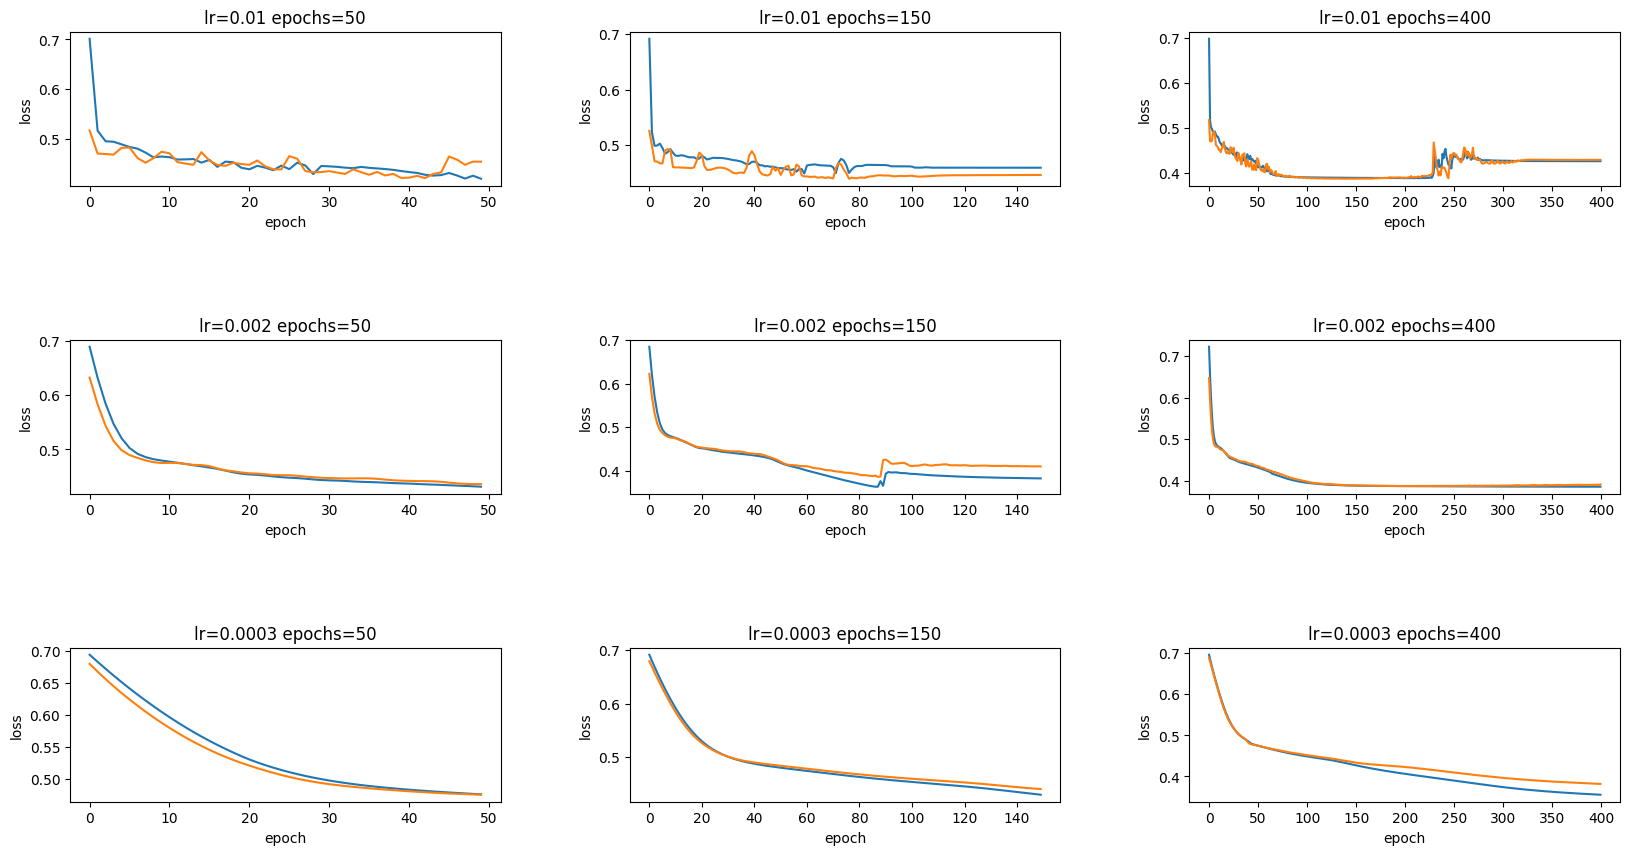

In [258]:
params = {
    "lr": [0.01, 0.002, 0.0003],
    "epochs": [50, 150, 400],
}

fig, axs = plt.subplots(3, 3, figsize=(20, 10))

index = 0
best_nn_model = None
loss = 1
for lr in params["lr"]:
    for epochs in params["epochs"]:
        # best activation functions
        activation_1 = nn.LeakyReLU(0.01)
        activation_2 = nn.LeakyReLU(0.01)

        model, train_loss, test_loss = train_network(lr, epochs, activation_1, activation_2)
        
        print(f'lr={lr} epochs={epochs} train_loss={train_loss[-1]} test_loss={test_loss[-1]}')
        if (best_nn_model is None) or (loss > test_loss[-1]):
            best_nn_model = model
            loss = test_loss[-1]

        row = index // 3
        col = index % 3
        axs[row][col].plot(train_loss, label="train")
        axs[row][col].plot(test_loss, label="test")
        axs[row][col].set_title(f'lr={lr} epochs={epochs}')
        axs[row][col].set_xlabel('epoch')
        axs[row][col].set_ylabel('loss')
        
        index += 1

plt.subplots_adjust(wspace=0.3, hspace=1)
plt.show()

По графикам можно сделать выводы: 
1. Если брать большой `lr`, то каждое обновление градиентов сильно подстраивает под конкретную выборку, что отражается в скачках ошибки на тестовой выборке.
2. При большом количестве эпох модель начинает переобучаться, то есть ошибка на обучении падает, а на тесте растет, поэтому большое количество эпох уместно использовать лишь с очень маленьким `lr`
3. Лучшая модель получилось при минимальном `lr` и максимальном `epochs` (причины выше), при чем этот результат можно улучшить уменьшив `lr` или увеличив `epochs`, но тогда затраты на время увеличатся.

Теперь рассмотрим результаты нейросетевой модели на тестовой выборке:

In [256]:
pred_probas = best_nn_model(x_test_tensor)

y_pred_nn = []
for prob in pred_probas:
    if prob[0] >= 0.5:
        y_pred_nn.append(0)
    else:
        y_pred_nn.append(1)

get_results("DenseNet", y_pred_nn)

DenseNet model
accuracy:  0.9285714285714286

confusion matrix
TP=21 FP=4
FN=4 TN=83

precision:  0.84
recall:  0.84
f1_score:  0.84


# Результаты моделей

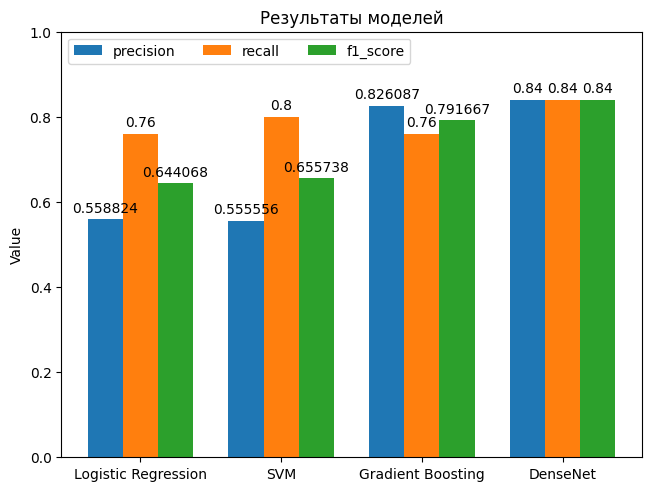

In [266]:
metrics = ['precision', 'recall', 'f1_score']
results2 = {}
for metric in metrics:
    results2[metric] = []
    for model in results.keys():
        results2[metric].append(results[model][metric])

x = np.arange(len(results))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in results2.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

plt.ylim(0, 1)
ax.set_ylabel('Value')
ax.set_title('Результаты моделей')
ax.set_xticks(x + width, results.keys())
ax.legend(loc='upper left', ncols=3)

plt.show()

Можно выделить победителя - модель нейросети. Думаю здесь основным преимуществом нейросети оказалось то, что она сама умеет отбирать из данных нужные ей признаки, а потом работать с ними, так она смогла очень хорошо приблизить истинную зависимость. Возможно, если бы данных было больше, победил бы градиентный бустинг, так как это лучшая модель для работы с табличными данными, но и нейросеть сильно улучшается при увеличении датасета.

# Анализ спектров куска ткани (2D формат)
Пусть нам даны показания спектроскопии взятые с куска ткани в формате {X (абсцисса), Y (ордината), длина волны (Wave), сила волны (Intensity)}, тогда будем считать их как 2D картинку, тогда можно обучить сверточную нейронную сеть для предсказания вида ткани (здоровая, больная, околоопухолевая) 

Загрузим наши данные

In [36]:
root_folder = "dataset2D"
all_files = {}

for folder in next(os.walk(root_folder))[1]:
    path = os.path.join(root_folder, folder)
    all_files[folder] = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

Убедимся, что данных приходят в правильном формате

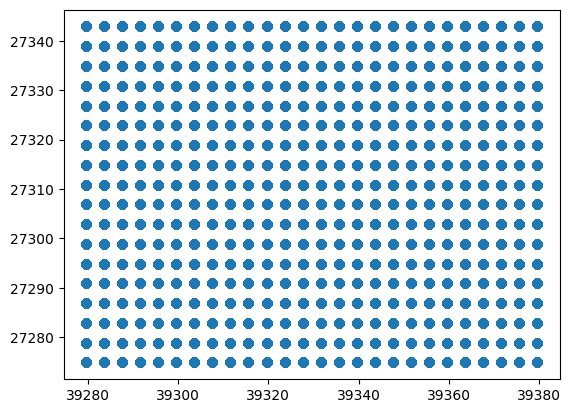

In [37]:
xx = []
yy = []
was = dict()
with open("dataset2D/healthy/image_cortex_patient13012020_633nm_obj20_power100_1sec_step4um_сenter2900_place1_20201009_1.txt", 'r') as fin:
    for line in fin.readlines()[1:]:
        x, y, wave, intensity = map(float, line.split('\t'))
        if (x, y) not in was.keys():
            xx.append(x)
            yy.append(y)
    plt.scatter(xx, yy)
    plt.show()

Теперь можем приступать к обработке датасета

In [38]:
count = {'sick': 0, 'healthy': 0, 'near-tumor': 0}

measurements = []
classifications = []

for folder in list(all_files):
    for txt in all_files[folder]:
        file =  os.path.join(root_folder, folder, txt)

        data = None
        with open(file, 'r') as fin:
            data = fin.readlines()

        mapped_xy = dict()
        xs = []
        ys = []
        for line in data[1:]:
            x, y, wave, intensity = map(float, line.split('\t'))
            if (x, y) not in mapped_xy.keys():
                mapped_xy[(x, y)] = {
                    'wave': [],
                    'intensity': []
                }
                xs.append(x)
                ys.append(y)
            mapped_xy[(x, y)]['wave'].append(wave)
            mapped_xy[(x, y)]['intensity'].append(intensity)
        
        xs = sorted(list(set(xs)))
        ys = sorted(list(set(ys)))
        
        width = len(xs)
        height = len(ys)

        table = [[[] for _ in range(20)] for __ in range(20)]
        for i in range(20):
            for j in range(20):
                x_index = int((i / 20) * width)
                y_index = int((j / 20) * height)
                d = mapped_xy[(xs[x_index], ys[y_index])]
                table[i][j] = extract_features(np.asarray(d['wave']), np.asarray(d['intensity']))

        measurements.append(table)
        
        if 'healthy' in folder:
            classifications.append([1, 0, 0])
        if 'sick' in folder:
            classifications.append([0, 1, 0])
        if 'near-tumor' in folder:
            classifications.append([0, 0, 1])
        
        count[folder] += 1

print(count)

{'sick': 4, 'healthy': 10, 'near-tumor': 11}


Имеем всего 4 экземпляра больного класса, поэтому нужно будет учитывать его с соответствующим весом.

Отнормируем данные

In [39]:
import copy

for_scale = []
for i in range(len(measurements)):
    for x in range(20):
        for y in range(20):
            temp = list(measurements[i][x][y])
            for_scale.append([x for x in temp])

scaler_2D = StandardScaler()
scaler_2D.fit(for_scale)

scaled_2D = scaler_2D.transform(for_scale)

train_2D_scaled = copy.deepcopy(measurements)
index = 0
for i in range(len(train_2D_scaled)):
    for x in range(20):
        for y in range(20):
            train_2D_scaled[i][x][y] = scaled_2D[index]
            index += 1

train_2D = [[[[0 for x in range(20)] for y in range(20)] for channel in range(29)] for elems in range(len(measurements))]
for i in range(len(train_2D_scaled)):
    for x in range(20):
        for y in range(20):
            for channel in range(29):
                train_2D[i][channel][x][y] = train_2D_scaled[i][x][y][channel]

train_2D_Y = [[[[classifications[i][class_type] for y in range(20)] for x in range(20)] for class_type in range(3)] for i in range(len(classifications))]

train_2D = (np.array(train_2D))
print(train_2D.shape)
            
train_2D_Y = (np.array(train_2D_Y))
print(train_2D_Y.shape)

(25, 29, 20, 20)
(25, 3, 20, 20)


Реализуем модель сверточной нейронной сети и обучим ее

In [49]:
import torch.nn.functional as F

class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()

        self.linear1 = nn.Linear(29, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 64)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = F.relu(self.linear1(x))
        x = x.permute(0, 3, 1, 2)
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = x.permute(0, 2, 3, 1)
        x = F.relu(self.linear2(x))
        x = x.permute(0, 3, 1, 2)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = x.permute(0, 2, 3, 1)
        x = F.relu(self.linear3(x))
        x = x.permute(0, 3, 1, 2)
        
        x = F.relu(self.conv5(x))
        x = self.softmax(x)
        
        return x

В обучаемой выборке имеем всего 26 элементов, поэтому мы будем сильно зависит от разделения выборки на обучение и тест. Чтобы избавиться от такой зависимости будет обучаться, используя метод кросс валидации, то есть весь датасет делится на блоки и далее перебирается блок, который будет тестовой выборкой, а все остальные блоки формируют обучающую выборку.

In [189]:
from sklearn.model_selection import KFold

def train_nn_model_2D(train_2D, train_2D_Y, params):    
    fig, axs = plt.subplots(3, 3, figsize=(20, 10))
    
    index = 0
    best_nn_model_2D = None
    min_loss = 100
    folds = 3
    kf = KFold(n_splits=folds)
    
    for lr in params["lr"]:
        for epochs in params["epochs"]:
            model = FCN()
            criterion = nn.CrossEntropyLoss(weight=params["class_weights"])
            optimizer = optim.Adam(model.parameters(), lr=lr)
            train_loss = []
            test_loss = []
    
            for epoch in range(epochs // folds):
                curr_train_loss = 0
                curr_test_loss = 0
                for fold, (train_index, val_index) in enumerate(kf.split(train_2D)):
                    fold_x_train, fold_y_train = train_2D[train_index], train_2D_Y[train_index]
                    fold_x_val, fold_y_val = train_2D[val_index], train_2D_Y[val_index]
    
                    fold_x_train = torch.from_numpy(np.array(fold_x_train, dtype=np.float32))
                    fold_y_train = torch.from_numpy(np.array(fold_y_train, dtype=np.float32))
                    fold_x_val = torch.from_numpy(np.array(fold_x_val, dtype=np.float32))
                    fold_y_val = torch.from_numpy(np.array(fold_y_val, dtype=np.float32))
                    
                    optimizer.zero_grad()
                    outputs = model(fold_x_train)
        
                    # print("probas", outputs[0][0][0][0], outputs[0][1][0][0], outputs[0][2][0][0])
                    
                    loss = criterion(outputs, fold_y_train)
                    loss.backward()
                    optimizer.step()
                    
                    # print(f"Epoch {epoch+1}, Loss: {loss.item()}")
                    curr_train_loss += loss.item()
                    curr_test_loss += criterion(model(fold_x_val), fold_y_val).item()
                    
                train_loss.append(curr_train_loss / folds)
                test_loss.append(curr_test_loss / folds)
            
            print(f'lr={lr} epochs={epochs} train_loss={train_loss[-1]} test_loss={test_loss[-1]}')
            if (best_nn_model_2D is None) or (min_loss > test_loss[-1]):
                best_nn_model_2D = model
                min_loss = test_loss[-1]
    
            row = index // 3
            col = index % 3
            axs[row][col].plot(train_loss, label="train")
            axs[row][col].plot(test_loss, label="test")
            axs[row][col].set_title(f'lr={lr} epochs={epochs}')
            axs[row][col].set_xlabel('epoch')
            axs[row][col].set_ylabel('loss')
            
            index += 1
    
    plt.subplots_adjust(wspace=0.3, hspace=1)
    plt.show()
    return best_nn_model_2D

lr=0.0004 epochs=20 train_loss=1.7794403632481892 test_loss=1.7893640597661336
lr=0.0004 epochs=30 train_loss=1.5735137462615967 test_loss=1.557900349299113
lr=0.0004 epochs=100 train_loss=1.3442695140838623 test_loss=1.325670639673869
lr=0.0006 epochs=20 train_loss=1.784841259320577 test_loss=1.7989776531855266
lr=0.0006 epochs=30 train_loss=1.7829034328460693 test_loss=1.7946653366088867
lr=0.0006 epochs=100 train_loss=1.2971076567967732 test_loss=1.2937551339467366
lr=0.0003 epochs=20 train_loss=1.7840447425842285 test_loss=1.7986385822296143
lr=0.0003 epochs=30 train_loss=1.6058087348937988 test_loss=1.5800149043401082
lr=0.0003 epochs=100 train_loss=1.3042490084966023 test_loss=1.2949696779251099


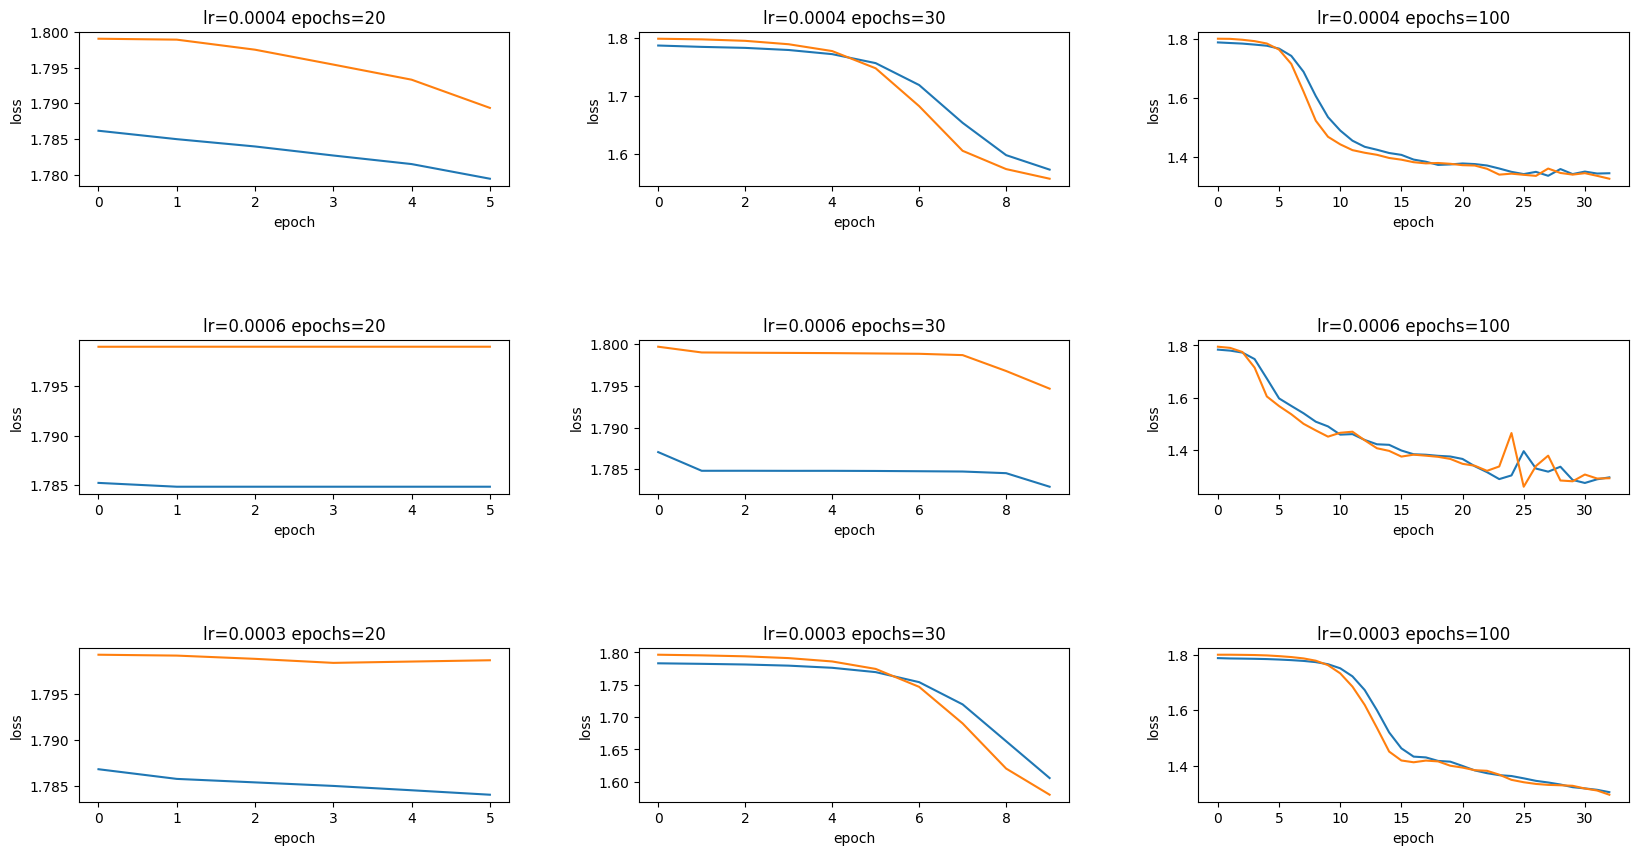

In [243]:
params = {
    "lr": [0.0004, 0.0006, 0.0003],
    "epochs": [20, 30, 100],
    "class_weights": torch.tensor([1.2, 3, 1.5], dtype=torch.float32)
}
best_nn_model_2D = train_nn_model_2D(train_2D, train_2D_Y, params)

Так как мы обучались с помощью метода кросс валидации, то при обучении мы учитывали всю выборку, поэтому ошибка на тесте приблизительно равна ошибке на обучении. Скачки на графиках также из-за кросс валидации, так как обучаемся несколько раз и только потом записываем ошибку. После обучения получаем немаленькую ошибку, скорее всего это связано не только с маленьким размером обучающей выборки, но и форматом модели и подходом к обучению, возможно идея с пространственной зависимостью здесь не совсем применима. Если бы у нас был датасет, где для каждой точки измерения размечен класс, то модель показывала бы наилучшие результаты как в обучении, так и в применении.

# Обучение 2.0
Давайте разметим датасет сами, используя уже обученную модель нейросети для одномерных показаний. Тогда модель выша должна сильно прибавить в качестве.

In [224]:
from math import e

train_2D_Y_2 = [[[[0.0 for y in range(20)] for x in range(20)] for class_type in range(3)] for i in range(len(classifications))]

for i in range(len(classifications)):
    for x in range(20):
        for y in range(20):
            factors = []
            for channel in range(29):
                factors.append(train_2D[i][channel][x][y])

            tensor = torch.from_numpy(np.array([factors])).to(torch.float32)
            nn_probas = list(best_nn_model(tensor)[0].detach().numpy())

            p_h = nn_probas[0] + classifications[i][0] / 4
            p_s = nn_probas[1] + classifications[i][1] / 4
            p_n = 0.5 - (max(p_h, p_s) - min(p_h, p_s)) / 2 + classifications[i][2] / 4

            norm = e**p_h + e**p_s + e**p_n

            p_h = e**p_h / norm
            p_s = e**p_s / norm
            p_n = e**p_n / norm
            
            train_2D_Y_2[i][0][x][y] = p_h
            train_2D_Y_2[i][1][x][y] = p_s
            train_2D_Y_2[i][2][x][y] = p_n

train_2D_Y_2 = (np.array(train_2D_Y_2))
print(train_2D_Y.shape)

(25, 3, 20, 20)


lr=0.0003 epochs=20 train_loss=1.9458919366200764 test_loss=1.9493891795476277
lr=0.0003 epochs=30 train_loss=1.911310076713562 test_loss=1.9068726301193237
lr=0.0003 epochs=100 train_loss=1.8415613174438477 test_loss=1.8451767365137737
lr=0.0004 epochs=20 train_loss=1.9103104670842488 test_loss=1.9099257787068684
lr=0.0004 epochs=30 train_loss=1.8896247545878093 test_loss=1.8898332913716633
lr=0.0004 epochs=100 train_loss=1.839419682820638 test_loss=1.8428831497828166
lr=0.0005 epochs=20 train_loss=1.901438593864441 test_loss=1.8994406859079997
lr=0.0005 epochs=30 train_loss=1.8810071150461833 test_loss=1.882840355237325
lr=0.0005 epochs=100 train_loss=1.9262561400731404 test_loss=1.9319458802541096


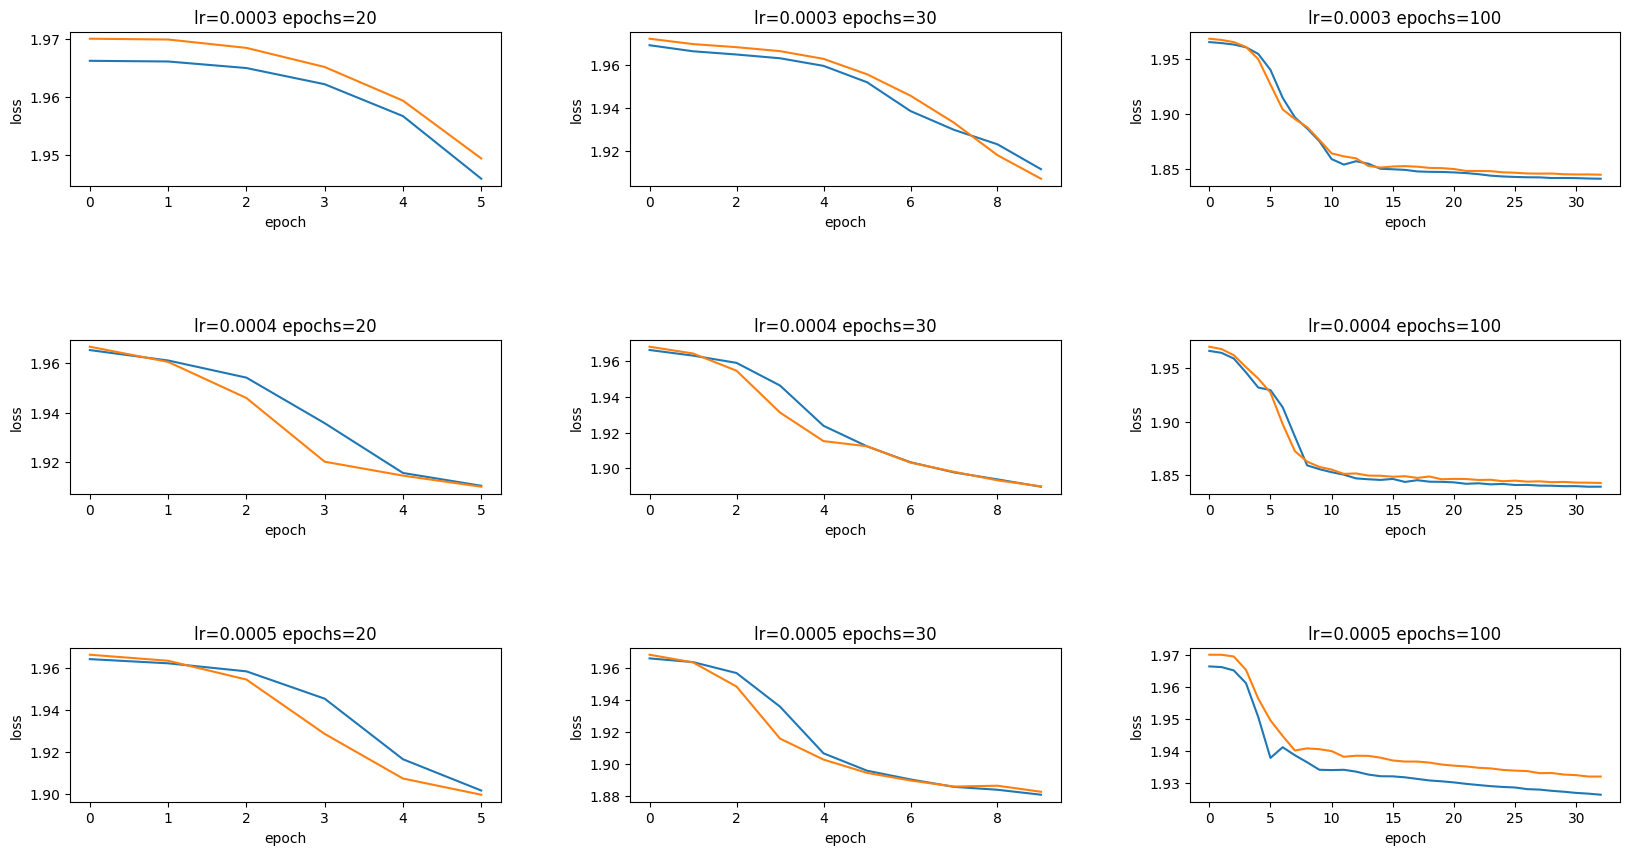

In [244]:
params = {
    "lr": [0.0003, 0.0004, 0.0005],
    "epochs": [20, 30, 100],
    "class_weights": torch.tensor([1.3, 2.5, 2], dtype=torch.float32)
}
best_nn_model_2D_2 = train_nn_model_2D(train_2D, train_2D_Y_2, params)

Сохраним обученные модели как файлы для дальнейшего использования. В ноутбуке RunModels можно будет запустить модели на входных данных и узнать вероятность болезни ткани указав показания спектроскопии. Показания можно указывать в 1D, 2D форматах.

In [267]:
import joblib
# Logistic Regression Model
joblib.dump(log_reg_model, 'data/LogisticRegressionModel.sav')

# Neural Net
joblib.dump(scaler, 'data/StandartScaler.sav')
torch.save(best_nn_model.state_dict(), 'data/NeuralNetwork.pth')

# Neural Net 2D
joblib.dump(scaler_2D, 'data/StandartScaler2D.sav')
torch.save(best_nn_model_2D.state_dict(), 'data/NeuralNetwork2D.pth')
torch.save(best_nn_model_2D_2.state_dict(), 'data/NeuralNetwork2D2.pth')